In [6]:
%%capture
!pip install num2words
!pip install pymystem3
!pip install nltk
! pip install transliterate
!pip install catboost
#!pip install lightgbm

In [7]:
import re
import csv
import string
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from num2words import num2words
from pymystem3 import Mystem
from transliterate import translit
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
product = pd.read_csv('marketing_product.csv', sep=';')

In [9]:
dealerprice = pd.read_csv('marketing_dealerprice.csv', sep=';')

In [10]:
productdealer = pd.read_csv('marketing_productdealerkey.csv', sep=';')

In [11]:
merged_df = pd.merge(dealerprice, productdealer, left_on='product_key', right_on='key', how='left')

# Добавление столбца 'product_id' из productdealer в dealerprice
dealerprice['product_id'] = merged_df['product_id']

In [12]:
dealerprice.sample(3)

id product_key   price  ...        date dealer_id product_id
18596  18747   684838504   384.0  ...  2023-07-28        18      156.0
5666    5801   700000627   569.0  ...  2023-07-14         4      401.0
4711    4852    23295803  2324.0  ...  2023-07-13        16      266.0

[3 rows x 8 columns]

In [13]:
dealerprice['product_id'].isna().sum()

2849

Попробуем заполнить пропуски в столбце product_id, сгруппировав по product_name

In [14]:
dealerprice['product_id'] = dealerprice.groupby('product_name')['product_id'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 0))

In [15]:
dealerprice['product_id'].isna().sum()

0

In [16]:
dealerprice[dealerprice['product_id'] == 0]

id product_key   price  ...        date dealer_id product_id
513      510  1001472231   695.0  ...  2023-07-11         5        0.0
554      590   932001058   590.0  ...  2023-07-11         4        0.0
592      589   932001057  1290.0  ...  2023-07-11         4        0.0
593      591      716501   189.0  ...  2023-07-11         2        0.0
629      626      546241   235.0  ...  2023-07-11         2        0.0
...      ...         ...     ...  ...         ...       ...        ...
20379  20534   901121737   506.0  ...  2023-07-31        18        0.0
20401  20556   528911039   507.0  ...  2023-07-31        18        0.0
20410  20565   685030286   445.0  ...  2023-07-31        18        0.0
20414  20569  1090913025   579.0  ...  2023-07-31        18        0.0
20415  20570  1077090171  2623.0  ...  2023-07-31        18        0.0

[2695 rows x 8 columns]

от 150 пропусков избавились, уже неплохо. Все остальное заполнили нулями

In [17]:
dealerprice['product_id'] = dealerprice['product_id'].astype(int)

In [18]:
dealerprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            20416 non-null  int64  
 1   product_key   20416 non-null  object 
 2   price         20416 non-null  float64
 3   product_url   20182 non-null  object 
 4   product_name  20416 non-null  object 
 5   date          20416 non-null  object 
 6   dealer_id     20416 non-null  int64  
 7   product_id    20416 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 1.2+ MB


Изучаем столбец name_1c

In [19]:
product['name_1c'].isna().sum()

11

Удалим пропуски

In [20]:
product = product.dropna(subset=['name_1c'])
product['name_1c'].isna().sum()

0

Напишем функцию для очистки текста в целевых столбцах

In [21]:
m = Mystem()

In [22]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('russian')
words_to_remove = ['один', 'два', 'три']  # Слова для удаления из списка стоп-слов

for word in words_to_remove:
    if word in stop_words:
        stop_words.remove(word)
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'эту', 'моя', 'впрочем', 'хорошо', 'свою

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def clean_text(text):

    def replace_numbers_with_words(words):
        for i in range(len(words)):
            word = words[i]
            if word.isdigit():
                num_word = num2words(int(word), lang='ru')
                words[i] = num_word

        replaced_text = ' '.join(words)
        return replaced_text

    text_no_punct = re.sub(rf"[{re.escape(''.join(set(string.punctuation) - {'.', ',', ':', '-' }))}]", " ", text)
    text_no_punct = text_no_punct.replace('.', ',')

    text_with_spaces = re.sub(r'(\d)([A-Za-zА-ЯЁа-яё])|([A-Za-zА-ЯЁа-яё])(\d)', r'\1 \2', text_no_punct)
    text_with_spaces = re.sub(r'(?<=[а-я])(?=[А-Я])|(?<=[a-z])(?=[A-Z])', ' ', text_with_spaces)
    text_with_spaces = re.sub(r'(\d+),(\d+)', r'\1.\2', text_with_spaces)
    text_with_spaces = re.sub(r'(\b)\,', r'\1', text_with_spaces)

    split_words = re.sub(r'(?<=[А-ЯЁа-яё])(?=[A-Za-z])|(?<=[A-Za-z])(?=[А-ЯЁа-яё])', ' ', text_with_spaces)
    split_words = re.sub(r'\bл\b', 'литр', split_words)
    split_words = re.sub(r'\bг\b', 'грамм', split_words)
    split_words = re.sub(r'\bкг\b', 'килограмм', split_words)
    split_words = re.sub(r'\bмл\b', 'миллилитр', split_words)
    split_words = split_words.lower()
    split_words = split_words.replace('prosept', '').replace('просепт', '').replace('жидкое', '').replace('средство', '')
    lemmatized_text = m.lemmatize(split_words)
    filtered_words = [word.strip() for word in lemmatized_text if word.lower().strip() not in stop_words]

    replaced_numbers_text = replace_numbers_with_words(filtered_words)
    transliterated_text = [translit(word, 'ru', reversed=True) for word in replaced_numbers_text]
    cleaned_text = "".join(transliterated_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

In [24]:
product['name_1c_clean'] = product['name_1c'].apply(clean_text)

In [25]:
product['name_1c_clean']

0      antiseptik nevymyvaemyj otvetstvennyj konstruk...
1      antigololed - tridtsat' dva gotovyj sostav dve...
2      germetik akrilovyj tsvet sosna f p shest'sot m...
3      konditsioner bel'e korolevskij iris crystal ri...
5      grunt betonokontakt gladkij poverhnost' nanese...
                             ...                        
491    uborka pomeschenie pozhar dezinfitsirujuschij ...
492    gel' stirka sherst' shelk delikatnyj tkan' cry...
493    c redstvo chistka gril' duhovka cooky grill ge...
494    professional'nyj myt'e pol polimernyj pokrytie...
495    usilennyj udalenie rzhavchina mineral'nyj otlo...
Name: name_1c_clean, Length: 485, dtype: object

In [26]:
dealerprice['product_name_clean'] = dealerprice['product_name'].apply(clean_text)

In [27]:
unique_df_1 = product.drop_duplicates(subset=['name_1c_clean'])

In [28]:
unique_df_2 = dealerprice.drop_duplicates(subset=['product_name_clean'])

In [29]:
unique_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 0 to 495
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         468 non-null    int64  
 1   id                 468 non-null    int64  
 2   article            468 non-null    object 
 3   ean_13             447 non-null    float64
 4   name               468 non-null    object 
 5   cost               467 non-null    float64
 6   recommended_price  467 non-null    float64
 7   category_id        430 non-null    float64
 8   ozon_name          443 non-null    object 
 9   name_1c            468 non-null    object 
 10  wb_name            441 non-null    object 
 11  ozon_article       350 non-null    float64
 12  wb_article         323 non-null    float64
 13  ym_article         321 non-null    object 
 14  wb_article_td      32 non-null     object 
 15  name_1c_clean      468 non-null    object 
dtypes: float64(6), int64(2), o

In [30]:
unique_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1864 entries, 0 to 20401
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1864 non-null   int64  
 1   product_key         1864 non-null   object 
 2   price               1864 non-null   float64
 3   product_url         1840 non-null   object 
 4   product_name        1864 non-null   object 
 5   date                1864 non-null   object 
 6   dealer_id           1864 non-null   int64  
 7   product_id          1864 non-null   int64  
 8   product_name_clean  1864 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 145.6+ KB


In [31]:
documents_set1_cleaned = np.array(unique_df_1['name_1c_clean'])

In [32]:
documents_set2_cleaned = np.array(unique_df_2['product_name_clean'])

Посмотрим на самые частые слова в двух датасетах

In [33]:
from collections import Counter
set2 = ' '.join(documents_set2_cleaned)

word_counts = Counter(set2.split(' '))

most_common_words_2 = word_counts.most_common(10)
print(most_common_words_2)

[('litr', 1257), ('odin', 693), ("pjat'", 683), ('-', 678), ('kontsentrat', 385), ('antiseptik', 334), ('kilogramm', 269), ('millilitr', 237), ("desjat'", 229), ('tri', 212)]


In [34]:
set1 = ' '.join(documents_set1_cleaned)

word_counts = Counter(set1.split(' '))

most_common_words_1 = word_counts.most_common(10)
print(most_common_words_1)

[('litr', 366), ('odin', 137), ("pjat'", 131), ('-', 101), ('antiseptik', 100), ('kontsentrat', 82), ('kilogramm', 59), ('dva', 56), ("myt'e", 54), ("gel'", 40)]


Векторизуем два набора данных найдем косинусные расстояния

In [35]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_set2 = tfidf_vectorizer.fit_transform(documents_set2_cleaned)
tfidf_matrix_set1 = tfidf_vectorizer.transform(documents_set1_cleaned)

In [36]:
similarities = cosine_similarity(tfidf_matrix_set2, tfidf_matrix_set1)

In [37]:
similarities.shape

(1864, 468)

In [38]:
for i, doc_set1 in enumerate(np.array(unique_df_2['product_name'])):
    similarities_for_doc = similarities[i]
    ranked_similarities = sorted(
        enumerate(similarities_for_doc),
        key=lambda x: x[1],
        reverse=True
    )
    print(f"Для документа '{doc_set1}' наиболее близкие пять документов из product['name']:")
    top_five = min(5, len(ranked_similarities))
    for idx, sim in ranked_similarities[:top_five]:
        unique_names = np.array(unique_df_1['name_1c']) 
        similar_doc = unique_names[idx]
        print(f"Документ '{similar_doc}' - сходство: {sim}")
    print("-------------------------------------------------------------")

Для документа 'Средство универсальное Prosept Universal Spray, 500мл' наиболее близкие пять документов из product['name']:
Документ 'Универсальное чистящее средство PROSEPT Universal Spray, 0.5 л.' - сходство: 0.776297083056862
Документ 'Профессиональное чистящее средство PROSEPT Universal Spray, 5 л.' - сходство: 0.6614541741682435
Документ 'Универсальное моющее и чистящее средствоUniversal Spray+концентрат 1:20-1:100 / 5 л' - сходство: 0.6123338579368451
Документ 'Профессиональное универсальное моющее средство Universal Prof' - сходство: 0.5625480834779285
Документ 'Профессиональное универсальное моющее средство Universal Prof, 1 л.' - сходство: 0.5452812081430172
-------------------------------------------------------------
Для документа 'Концентрат Prosept Multipower для мытья полов, цитрус 1л' наиболее близкие пять документов из product['name']:
Документ 'Концентрат для мытья полов и стен Multipower "Цитрус" концентрат / 0,8 л' - сходство: 0.8139368609950429
Документ 'Средство для

In [39]:
data = []

for i, doc_set1 in enumerate(np.array(unique_df_2['product_name'])):
    similarities_for_doc = similarities[i]
    ranked_similarities = sorted(
        enumerate(similarities_for_doc),
        key=lambda x: x[1],
        reverse=True
    )
    top_five = min(5, len(ranked_similarities))
    max_similarity = ranked_similarities[0][1]  
    
    product_id_dealer = unique_df_2['product_id'].iloc[i]

    for rank, (idx, sim) in enumerate(ranked_similarities[:top_five]):
        if idx < len(np.array(unique_df_1['name_1c'])):  
            doc_name_dealerprice = doc_set1
            doc_name_product = np.array(unique_df_1['name_1c'])[idx]
            product_id = unique_df_1['id'].iloc[idx] 

            if product_id_dealer == product_id:
                target = 1
            elif product_id_dealer == 0  and sim == max_similarity:
                target = 1
            else:
                target = 0

            data.append({
                'Документ_из_dealerprice': doc_name_dealerprice,
                'Документ_из_product': doc_name_product,
                'Сходство': sim,
                'Ранг': rank + 1,
                'product_id_dealer': product_id_dealer,
                'product_id': product_id,
                'target': target
            })
        else:
            print(f"Индекс {idx} выходит за границы.")

df_cos = pd.DataFrame(data)

In [40]:
#df_cos.to_csv('result_data.csv', index=False)

In [41]:
df_cos[df_cos['product_id_dealer'] == 0]

Документ_из_dealerprice  ... target
2290               Удалитель мха Prosept концентрат 1 л  ...      1
2291               Удалитель мха Prosept концентрат 1 л  ...      0
2292               Удалитель мха Prosept концентрат 1 л  ...      0
2293               Удалитель мха Prosept концентрат 1 л  ...      0
2294               Удалитель мха Prosept концентрат 1 л  ...      0
...                                                 ...  ...    ...
9315  Герметик акриловый межшовный для деревянных ко...  ...      1
9316  Герметик акриловый межшовный для деревянных ко...  ...      0
9317  Герметик акриловый межшовный для деревянных ко...  ...      0
9318  Герметик акриловый межшовный для деревянных ко...  ...      0
9319  Герметик акриловый межшовный для деревянных ко...  ...      0

[1435 rows x 7 columns]

In [42]:
df_cos['target'].value_counts()

0    7651
1    1669
Name: target, dtype: int64

In [43]:
df_cos.head()

Документ_из_dealerprice  ... target
0  Средство универсальное Prosept Universal Spray...  ...      1
1  Средство универсальное Prosept Universal Spray...  ...      0
2  Средство универсальное Prosept Universal Spray...  ...      0
3  Средство универсальное Prosept Universal Spray...  ...      0
4  Средство универсальное Prosept Universal Spray...  ...      0

[5 rows x 7 columns]

Результаты выглядят более менее адекватно

Попробуем использовать метод ближайших соседей

In [44]:
documents = np.concatenate([documents_set1_cleaned, documents_set2_cleaned])
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

tfidf_matrix_set1 = tfidf_matrix[:len(documents_set1_cleaned)]
tfidf_matrix_set2 = tfidf_matrix[len(documents_set1_cleaned):]

n_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(tfidf_matrix_set1)
distances, indices = nbrs.kneighbors(tfidf_matrix_set2)

Собираем таблицу для последующего обучения классификатора: добаляем столбец target, где в случае, если происходит совпадение product_id_dealer и product_id поставщика ставим 1, в случае отсутствующего product_id_dealer решили не удалять все такие строки, а поставить 1 строке с минимальным расстоянием из 5 предсказаний, в остальных случаях 0

In [45]:
data = []

for i, neighbors in enumerate(indices):
    distances_for_doc = distances[i]
    for rank, (idx, dist) in enumerate(zip(neighbors, distances_for_doc)):
        doc_name_set1 = documents_set1_cleaned[idx]  
        doc_name_set2 = documents_set2_cleaned[i]  

        if idx < len(np.array(unique_df_1['name_1c'])):  
            doc_name_dealerprice = np.array(unique_df_2['product_name'])[i]
            doc_name_product = np.array(unique_df_1['name_1c'])[idx]
            product_id_dealer = unique_df_2['product_id'].iloc[i]
            product_id = unique_df_1['id'].iloc[idx]  
            
            if product_id_dealer == product_id:
                target = 1
            elif product_id_dealer == 0 and rank == 0:  
                target = 1
            else:
                target = 0

            data.append({
                'document_set1': doc_name_set1,
                'document_set2': doc_name_set2,
                'name_dealerprice' : doc_name_dealerprice,
                'name_1c' : doc_name_product,
                'distance': dist,
                'rank': rank + 1,
                'product_id_dealer': product_id_dealer,
                'product_id': product_id,
                'target': target
            })
        else:
            print(f"Index {idx} is out of bounds.")

df_nn = pd.DataFrame(data)

In [46]:
df_nn.to_csv('result_data_NN.csv', index=False)

In [47]:
df_nn['target'].value_counts()

0    7672
1    1648
Name: target, dtype: int64

In [48]:
df_nn[df_nn['product_id_dealer'] == 0]

document_set1  ... target
2290    udalitel' moh kontsentrat kontsentrat odin litr  ...      1
2291                            udalitel' moh odin litr  ...      0
2292                           udalitel' moh pjat' litr  ...      0
2293  nabor udalitel' moh kontsentrat odin litr dva sht  ...      0
2294  nabor udalitel' moh gotovyj sostav odin litr d...  ...      0
...                                                 ...  ...    ...
9315        germetik akrilovyj tsvet oreh tri kilogramm  ...      1
9316             germetik akrilovyj tsvet oreh 0.6 litr  ...      0
9317       germetik akrilovyj tsvet oreh sem' kilogramm  ...      0
9318  germetik akrilovyj tsvet oreh pjatnadtsat' kil...  ...      0
9319  germetik akrilovyj tsvet oreh f p shest'sot mi...  ...      0

[1435 rows x 9 columns]

Попробуем использовать в качестве features столбцы document_set2 и document_set1, а также слитный столбец document_set2+document_set2, а также столбец distance

Добавим в таблицу объединенный столбец

In [49]:
df_nn['combined_documents'] = df_nn['document_set1'] + ' ' + df_nn['document_set2']

In [50]:
df_nn.sample(3)

document_set1  ...                                 combined_documents
822         antiseptik eco ultra korichnevyj pjat' litr  ...  antiseptik eco ultra korichnevyj pjat' litr ec...
4756  myt'e steklo zerkalo antistaticheskij effekt o...  ...  myt'e steklo zerkalo antistaticheskij effekt o...
7936  usilennyj udalenie rzhavchina mineral'nyj otlo...  ...  usilennyj udalenie rzhavchina mineral'nyj otlo...

[3 rows x 10 columns]

In [51]:
df_nn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9320 entries, 0 to 9319
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   document_set1       9320 non-null   object 
 1   document_set2       9320 non-null   object 
 2   name_dealerprice    9320 non-null   object 
 3   name_1c             9320 non-null   object 
 4   distance            9320 non-null   float64
 5   rank                9320 non-null   int64  
 6   product_id_dealer   9320 non-null   int64  
 7   product_id          9320 non-null   int64  
 8   target              9320 non-null   int64  
 9   combined_documents  9320 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 728.2+ KB


Чтобы потом еще раз не искать ближайших соседей, сразу сделаем валидационную выборку (первые 1865 строк)

Разделим сразу данные на train и test

In [52]:
X1 = df_nn[['document_set1', 'document_set2', 'distance']]
X2 = df_nn[['combined_documents', 'distance']]
y = df_nn['target']

In [53]:
X1_valid = X1.head(1865)
X1 = X1.drop(X1.index[:1865])
X1.head()


document_set1  ...  distance
1865  antiseptik banja sauna sauna kontsentrat pjat'...  ...  0.355000
1866        antiseptik banja sauna eco sauna pjat' litr  ...  0.379338
1867  antiseptik banja sauna sauna kontsentrat odin ...  ...  0.397068
1868      antiseptik banja sauna eco sauna desjat' litr  ...  0.421666
1869         myt' banja sauna multipower wood odin litr  ...  0.573493

[5 rows x 3 columns]

In [54]:
X2_valid = X2.head(1865)
X2 = X2.drop(X2.index[:1865])
X2.head()

combined_documents  distance
1865  antiseptik banja sauna sauna kontsentrat pjat'...  0.355000
1866  antiseptik banja sauna eco sauna pjat' litr ch...  0.379338
1867  antiseptik banja sauna sauna kontsentrat odin ...  0.397068
1868  antiseptik banja sauna eco sauna desjat' litr ...  0.421666
1869  myt' banja sauna multipower wood odin litr chi...  0.573493

In [55]:
y_valid = y.head(1865)
y = y.drop(y.index[:1865])
y.head()

1865    0
1866    0
1867    0
1868    0
1869    0
Name: target, dtype: int64

In [56]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42, shuffle = True, stratify = y)

In [57]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42, shuffle = True, stratify = y)

In [58]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X2_train['combined_documents'])
X_test_tfidf = tfidf_vectorizer.transform(X2_test['combined_documents'])
X_valid_tfidf = tfidf_vectorizer.transform(X2_valid['combined_documents'])

In [59]:
columns = tfidf_vectorizer.get_feature_names_out()
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=columns)
X_train_tfidf = np.concatenate((X2_train['distance'][:, np.newaxis], X_train_tfidf), axis=1)

In [60]:
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=columns)
X_test_tfidf = np.concatenate((X2_test['distance'][:, np.newaxis], X_test_tfidf), axis=1)

In [61]:
X_valid_tfidf = pd.DataFrame(X_valid_tfidf.toarray(), columns=columns)
X_valid_tfidf = np.concatenate((X2_valid['distance'][:, np.newaxis], X_valid_tfidf), axis=1)

In [62]:
tfidf_vectorizer_full = TfidfVectorizer()
X_full_tfidf = tfidf_vectorizer_full.fit_transform(X2['combined_documents'])

In [63]:
columns = tfidf_vectorizer_full.get_feature_names_out()
X_full_tfidf = pd.DataFrame(X_full_tfidf.toarray(), columns=columns)
X_full_tfidf = np.concatenate((X2['distance'][:, np.newaxis], X_full_tfidf), axis=1)

Логистическая регрессия

In [64]:
#model_lr = LogisticRegression(class_weight='balanced', random_state=42)

#params = {'penalty' : ['l2'],
#           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

#gs_lr = GridSearchCV(model_lr, params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2, error_score='raise')
#gs_lr.fit(X, y)

In [65]:
#gs_lr.best_score_, gs_lr.best_params_

(0.8130678552339742, {'penalty': 'l2', 'solver': 'saga'})

In [66]:
# Обучение классификатора
clf = LogisticRegression(class_weight='balanced', penalty = 'l2', solver = 'saga')
clf.fit(X_train_tfidf, y2_train)

LogisticRegression(class_weight='balanced', solver='saga')

In [67]:
y_pred = clf.predict(X_test_tfidf)

accuracy = accuracy_score(y2_test, y_pred)
report = classification_report(y2_test, y_pred)

In [68]:
accuracy

0.7484909456740443

In [69]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1229
           1       0.38      0.70      0.50       262

    accuracy                           0.75      1491
   macro avg       0.65      0.73      0.66      1491
weighted avg       0.83      0.75      0.77      1491



CatBoostClassifier без кодирования категориальных признаков

In [70]:
categorical = ['combined_documents']
numeric_features = ['distance']

In [71]:
X2_train_cat = X2_train.copy()
X2_train_cat[categorical] = X2_train_cat[categorical].astype('category')
X2_test_cat = X2_test.copy()
X2_test_cat[categorical] = X2_test_cat[categorical].astype('category')
X2 = X2.copy()
X2[categorical] = X2[categorical].astype('category')
X2_valid_cat = X2_valid.copy()
X2_valid_cat[categorical] = X2_valid_cat[categorical].astype('category')

In [73]:
#model = CatBoostClassifier(cat_features=categorical, random_state=42)

#params = {'learning_rate': [0.2, 0.4, 0.8],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [3, 5, 8],
#        'iterations': [200, 250, 500]}

#s_ctb_ = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2, error_score='raise')
#gs_ctb_.fit(X2, y)

In [74]:
#gs_ctb_.best_score_, gs_ctb_.best_params_

(0.7595160421928899, {'iterations': 200, 'learning_rate': 0.2})

Получилcя roc_auc как у логистической регрессии

попробуем обучиться на столбцах отдельно

In [75]:
categorical = ['document_set1', 'document_set2']
numeric_features = ['distance']

In [76]:
X1_train_cat = X1_train.copy()
X1_train_cat[categorical] = X1_train_cat[categorical].astype('category')
X1_test_cat = X1_test.copy()
X1_test_cat[categorical] = X1_test_cat[categorical].astype('category')
X1 = X1.copy()
X1[categorical] = X1[categorical].astype('category')
X1_valid_cat = X1_valid.copy()
X1_valid_cat[categorical] = X1_valid_cat[categorical].astype('category')

In [78]:
#model = CatBoostClassifier(cat_features=categorical, random_state=42)

#params = {'learning_rate': [0.2, 0.4, 0.8],
#        'depth': [4, 6, 10],
#        'l2_leaf_reg': [3, 5, 8],
#        'iterations': [200, 250, 500]}

#gs_ctb_ = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2, error_score='raise')
#gs_ctb_.fit(X1, y)

In [80]:
#gs_ctb_.best_score_, gs_ctb_.best_params_

(0.7264269191025041, {'iterations': 200, 'learning_rate': 0.2})

Roc-auc ниже, чем у логистической регрессии, но из интереса попробуем обучить модель

In [81]:
ctb_ = CatBoostClassifier(random_state=42, iterations=200, learning_rate=0.2, cat_features=['document_set1', 'document_set2'])
ctb_.fit(X1_train_cat, y1_train)

0:	learn: 0.5672474	total: 51.5ms	remaining: 10.2s
1:	learn: 0.4921557	total: 56.3ms	remaining: 5.57s
2:	learn: 0.4033623	total: 60.1ms	remaining: 3.94s
3:	learn: 0.3622257	total: 63.6ms	remaining: 3.12s
4:	learn: 0.3494574	total: 67.1ms	remaining: 2.62s
5:	learn: 0.3434668	total: 69.3ms	remaining: 2.24s
6:	learn: 0.3274589	total: 73.1ms	remaining: 2.02s
7:	learn: 0.3169068	total: 76.8ms	remaining: 1.84s
8:	learn: 0.3110047	total: 80.5ms	remaining: 1.71s
9:	learn: 0.3050067	total: 83.8ms	remaining: 1.59s
10:	learn: 0.3032686	total: 87.3ms	remaining: 1.5s
11:	learn: 0.3015884	total: 90.5ms	remaining: 1.42s
12:	learn: 0.2995488	total: 93.9ms	remaining: 1.35s
13:	learn: 0.2987813	total: 97.1ms	remaining: 1.29s
14:	learn: 0.2951004	total: 101ms	remaining: 1.24s
15:	learn: 0.2925192	total: 103ms	remaining: 1.19s
16:	learn: 0.2917377	total: 106ms	remaining: 1.14s
17:	learn: 0.2887430	total: 110ms	remaining: 1.11s
18:	learn: 0.2887253	total: 111ms	remaining: 1.06s
19:	learn: 0.2886903	total: 

In [82]:
y_pred = ctb_.predict(X1_test_cat)

accuracy = accuracy_score(y1_test, y_pred)
report = classification_report(y1_test, y_pred)

In [83]:
accuracy

0.9014084507042254

In [84]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1229
           1       0.78      0.61      0.68       262

    accuracy                           0.90      1491
   macro avg       0.85      0.79      0.81      1491
weighted avg       0.90      0.90      0.90      1491



In [85]:
predicted_probabilities = ctb_.predict_proba(X1_valid)

In [86]:
X1_valid['Predicted_Probabilities_Class0'] = predicted_probabilities[:, 0]
X1_valid['Predicted_Probabilities_Class1'] = predicted_probabilities[:, 1]
X1_valid['target'] = y_valid
X1_valid.head(35)

document_set1  ... target
0     universal'nyj chistit' universal spray 0.5 litr  ...      1
1   professional'nyj chistit' universal spray pjat...  ...      0
2   universal'nyj myt' chistit' universal spray ko...  ...      0
3   professional'nyj universal'nyj myt' universal ...  ...      0
4   professional'nyj universal'nyj myt' universal ...  ...      0
5   kontsentrat myt'e pol stena multipower tsitrus...  ...      0
6   myt'e pol multipower tsitrus , dva shtuka 0.8 ...  ...      0
7   nabor kontsentrat myt'e pol stena multipower t...  ...      0
8               myt'e pol multipower citrus odin litr  ...      1
9                myt'e pol multipower floor odin litr  ...      0
10  nesmyvaemyj ochistka ljustra universal anti - ...  ...      1
11   nabor ljustra anti - dust sprej 0.5 litr dva sht  ...      0
12   nabor ljustra anti - dust sprej 0.5 litr tri sht  ...      0
13  sprej chistka gril' duhovka cooky grill pjat's...  ...      0
14  c redstvo chistka gril' duhovka cooky grill ge...  ...      0
15         udalitel' rzhavchina rust remover 0.5 litr  ...      1
16  udalitel' rzhavchina rust remover kontsentrat ...  ...      0
17  udalitel' rzhavchina rust remover kontsentrat ...  ...      0
18                           udalitel' moh pjat' litr  ...      0
19                            udalitel' moh odin litr  ...      0
20         myt' banja sauna multipower wood odin litr  ...      1
21         nabor banja universal wood multipower wood  ...      0
22  antiseptik banja sauna sauna kontsentrat odin ...  ...      0
23  sprej ochistka polk banja sauna universal wood...  ...      0
24  antiseptik banja sauna sauna kontsentrat pjat'...  ...      0
25  propitka kamen' aquaisol gidrofobizirovat' sos...  ...      1
26  propitka kamen' aquaisol gidrofobizirovat' sos...  ...      0
27           lak kamen' effekt mokryj kamen' dva litr  ...      0
28      zaschitnyj propitka moh kontsentrat odin litr  ...      0
29           lak kamen' effekt mokryj kamen' 0.9 litr  ...      0
30  myt'e plitka keramogranit multipower kerama od...  ...      1
31  myt'e plitka keramogranit multipower kerama pj...  ...      0
32              myt'e pol multipower citrus odin litr  ...      0
33               myt'e pol multipower floor odin litr  ...      0
34         myt' banja sauna multipower wood odin litr  ...      0

[35 rows x 6 columns]

In [87]:
result = (
    X1_valid.groupby(X1_valid.index // 5)
    .apply(lambda x: x.sort_values(by='Predicted_Probabilities_Class1', ascending=False))
    .reset_index(drop=True)
)
result

document_set1  ... target
0     universal'nyj myt' chistit' universal spray ko...  ...      0
1       universal'nyj chistit' universal spray 0.5 litr  ...      1
2     professional'nyj universal'nyj myt' universal ...  ...      0
3     professional'nyj universal'nyj myt' universal ...  ...      0
4     professional'nyj chistit' universal spray pjat...  ...      0
...                                                 ...  ...    ...
1860              lak banja sauna termostojkij 0.9 litr  ...      0
1861         myt' banja sauna multipower wood odin litr  ...      1
1862              lak banja sauna termostojkij dva litr  ...      0
1863  antiseptik banja sauna sauna kontsentrat odin ...  ...      0
1864  antiseptik banja sauna sauna kontsentrat pjat'...  ...      0

[1865 rows x 6 columns]

Парадоксальный результат, скоры на тесте не самые плохие, но по факту модель работает очень плохо

CatBoost c предварительно кодированными категориальными признаками

На векторизованном объединенном столбце combined_documents и столбце distance обучим CatBoost на предварительно обработанных данных, хотя CatBoost может работать с ними и напрямую

In [130]:
#model = CatBoostClassifier(random_state = 42)

#params = {'learning_rate': [0.1, 0.2],
#          'depth': [4, 10],
#          'l2_leaf_reg': [3, 8],
#          'iterations': [500, 750]}

#gs_ctb = GridSearchCV(model, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
#gs_ctb.fit(X_train_tfidf, y2_train)

In [89]:
#gs_ctb.best_score_, gs_ctb.best_params_

(0.89801171731434,
 {'depth': 10, 'iterations': 750, 'l2_leaf_reg': 3, 'learning_rate': 0.2})

In [90]:
ctb = CatBoostClassifier(random_state = 42, depth = 10, l2_leaf_reg = 3, iterations = 750, learning_rate = 0.2)
ctb.fit(X_train_tfidf, y2_train)

0:	learn: 0.5802620	total: 89.7ms	remaining: 1m 7s
1:	learn: 0.5089897	total: 176ms	remaining: 1m 5s
2:	learn: 0.4561577	total: 255ms	remaining: 1m 3s
3:	learn: 0.4194124	total: 334ms	remaining: 1m 2s
4:	learn: 0.3978440	total: 414ms	remaining: 1m 1s
5:	learn: 0.3815207	total: 495ms	remaining: 1m 1s
6:	learn: 0.3696692	total: 576ms	remaining: 1m 1s
7:	learn: 0.3647856	total: 654ms	remaining: 1m
8:	learn: 0.3545725	total: 735ms	remaining: 1m
9:	learn: 0.3438545	total: 817ms	remaining: 1m
10:	learn: 0.3343396	total: 901ms	remaining: 1m
11:	learn: 0.3264640	total: 990ms	remaining: 1m
12:	learn: 0.3232729	total: 1.07s	remaining: 1m
13:	learn: 0.3194685	total: 1.16s	remaining: 1m
14:	learn: 0.3132067	total: 1.24s	remaining: 1m
15:	learn: 0.3107749	total: 1.32s	remaining: 1m
16:	learn: 0.3084547	total: 1.4s	remaining: 1m
17:	learn: 0.3014388	total: 1.48s	remaining: 1m
18:	learn: 0.2983447	total: 1.56s	remaining: 59.9s
19:	learn: 0.2968573	total: 1.64s	remaining: 59.8s
20:	learn: 0.2960711	to

In [91]:
y_pred = ctb.predict(X_test_tfidf)

accuracy = accuracy_score(y2_test, y_pred)
report = classification_report(y2_test, y_pred)

In [92]:
accuracy

0.8926894701542589

In [93]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1229
           1       0.79      0.53      0.63       262

    accuracy                           0.89      1491
   macro avg       0.85      0.75      0.79      1491
weighted avg       0.89      0.89      0.88      1491



Метрики достаточно хорошие, будем работать с этой моделью, посмотрим, что получается на валидационной выборке

In [94]:
predicted_probabilities = ctb.predict_proba(X_valid_tfidf)

In [95]:
X1_valid['Predicted_Probabilities_Class1'] = predicted_probabilities[:, 1]
X1_valid['target'] = y_valid
X1_valid['name_dealerprice'] = df_nn['name_dealerprice']
X1_valid['name_1c'] = df_nn['name_1c']
X1_valid.drop(['document_set1', 'document_set2'], axis = 1, inplace = True)
X1_valid


distance  ...                                            name_1c
0     0.229923  ...  Универсальное чистящее средство PROSEPT Univer...
1     0.345664  ...  Профессиональное чистящее средство PROSEPT Uni...
2     0.392031  ...  Универсальное моющее и чистящее средствоUniver...
3     0.440355  ...  Профессиональное универсальное моющее средство...
4     0.457419  ...  Профессиональное универсальное моющее средство...
...        ...  ...                                                ...
1860  0.410797  ...  Моющее средство для бани и сауны PROSEPT Multi...
1861  0.588545  ...  Антисептик для бани и сауны PROSEPT SAUNA, кон...
1862  0.653488  ...  Лак для бани и сауны термостойкий PROSEPT, 0.9 л.
1863  0.667636  ...  Антисептик для бани и сауны PROSEPT SAUNA, кон...
1864  0.670057  ...    Лак для бани и сауны термостойкий PROSEPT, 2 л.

[1865 rows x 6 columns]

In [96]:
result = (
    X1_valid.groupby(X1_valid.index // 5)
    .apply(lambda x: x.sort_values(by='Predicted_Probabilities_Class1', ascending=False))
    .reset_index(drop=True)
)
result

distance  ...                                            name_1c
0     0.229923  ...  Универсальное чистящее средство PROSEPT Univer...
1     0.440355  ...  Профессиональное универсальное моющее средство...
2     0.345664  ...  Профессиональное чистящее средство PROSEPT Uni...
3     0.457419  ...  Профессиональное универсальное моющее средство...
4     0.392031  ...  Универсальное моющее и чистящее средствоUniver...
...        ...  ...                                                ...
1860  0.410797  ...  Моющее средство для бани и сауны PROSEPT Multi...
1861  0.653488  ...  Лак для бани и сауны термостойкий PROSEPT, 0.9 л.
1862  0.588545  ...  Антисептик для бани и сауны PROSEPT SAUNA, кон...
1863  0.670057  ...    Лак для бани и сауны термостойкий PROSEPT, 2 л.
1864  0.667636  ...  Антисептик для бани и сауны PROSEPT SAUNA, кон...

[1865 rows x 6 columns]

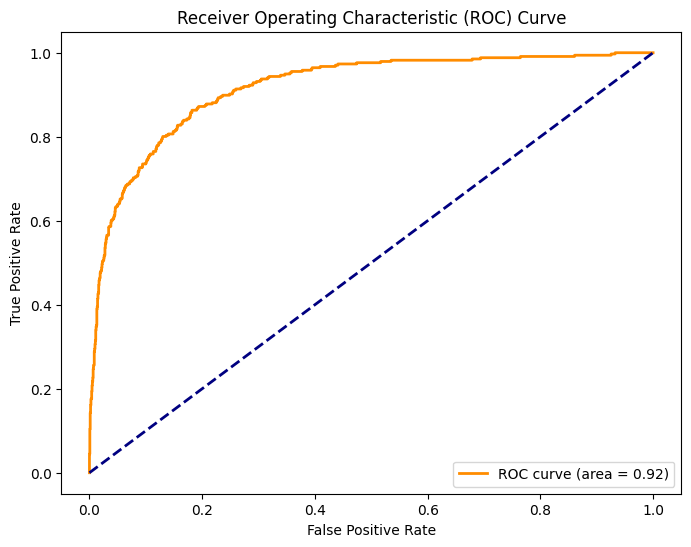

In [129]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [98]:
def compute_metrics(group):
    top_5 = group.nlargest(5, 'Predicted_Probabilities_Class1')
    true_positives = (top_5['target'] == 1).sum() 
    actual_positives = (group['target'] == 1).sum()  
    accuracy_5 = true_positives / 5  # Accuracy@5
    recall_5 = true_positives / actual_positives if actual_positives != 0 else 0  # Recall@5
    mrr_5 = 1 / (top_5['target'].values.argmax() + 1) if (top_5['target'] == 1).any() else 0  # MRR@5
    return pd.Series({'accuracy@5': accuracy_5, 'recall@5': recall_5, 'mrr@5': mrr_5})

metrics = (
    X1_valid.groupby(np.arange(len(X1_valid)) // 5)
    .apply(compute_metrics)
    .mean()
)
print(metrics)

accuracy@5    0.180161
recall@5      0.900804
mrr@5         0.806032
dtype: float64


На валидационной выборке метрики:   
accuracy@5    0.180161    
recall@5      0.900804    
mrr@5         0.806032  

In [99]:
model_ctb = CatBoostClassifier(random_state = 42, depth = 10, l2_leaf_reg = 3, iterations = 750, learning_rate = 0.2)
model_ctb.fit(X_full_tfidf, y)

0:	learn: 0.5648760	total: 98ms	remaining: 1m 13s
1:	learn: 0.4923996	total: 194ms	remaining: 1m 12s
2:	learn: 0.4562026	total: 287ms	remaining: 1m 11s
3:	learn: 0.4306823	total: 384ms	remaining: 1m 11s
4:	learn: 0.4100946	total: 482ms	remaining: 1m 11s
5:	learn: 0.3878625	total: 577ms	remaining: 1m 11s
6:	learn: 0.3698157	total: 672ms	remaining: 1m 11s
7:	learn: 0.3551405	total: 770ms	remaining: 1m 11s
8:	learn: 0.3471032	total: 859ms	remaining: 1m 10s
9:	learn: 0.3382944	total: 950ms	remaining: 1m 10s
10:	learn: 0.3330164	total: 1.04s	remaining: 1m 10s
11:	learn: 0.3261689	total: 1.14s	remaining: 1m 9s
12:	learn: 0.3220739	total: 1.23s	remaining: 1m 9s
13:	learn: 0.3162528	total: 1.33s	remaining: 1m 9s
14:	learn: 0.3143105	total: 1.42s	remaining: 1m 9s
15:	learn: 0.3133292	total: 1.52s	remaining: 1m 9s
16:	learn: 0.3100585	total: 1.6s	remaining: 1m 9s
17:	learn: 0.3074631	total: 1.69s	remaining: 1m 8s
18:	learn: 0.3054236	total: 1.78s	remaining: 1m 8s
19:	learn: 0.3041459	total: 1.87

In [100]:
import pickle
with open('trained_catboost_model.pkl', 'wb') as file:
    pickle.dump(model_ctb, file)

In [101]:
#result_df.to_csv('result_data.csv', index=False)

лучший результат

Хочется верить, что проклятие размерности нас не коснулось

CNN и LSTM не доделано, но модели успешно обучаются

In [102]:
%%capture
!pip install torchmetrics

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download("punkt")
from torchmetrics import F1Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix


[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_nn['combined_documents'], df_nn['target'], test_size=0.2, random_state=42, shuffle = True)

In [105]:
y_full = df_nn['target']

In [106]:
X_full = df_nn['combined_documents']

In [107]:
train_corpus = list(X_train)

In [108]:
full_corpus = list(X_full)

In [109]:
tokens = []
for text in tqdm(train_corpus):
  tokens.extend(word_tokenize(text))
tokens_filtered = [word for word in tokens if word.isalnum()]

  0%|          | 0/7456 [00:00<?, ?it/s]

In [110]:
tokens_full = []
for text in tqdm(full_corpus):
  tokens.extend(word_tokenize(text))
tokens_filtered_full = [word for word in tokens if word.isalnum()]

  0%|          | 0/9320 [00:00<?, ?it/s]

In [111]:
max_words = 10000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words) if len(pair[0]) > 2]

In [112]:
max_words = 10000
dist = FreqDist(tokens_filtered_full)
tokens_filtered_top_full = [pair[0] for pair in dist.most_common(max_words) if len(pair[0]) > 2]

In [113]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [114]:
vocabulary_full = {v: k for k, v in dict(enumerate(tokens_filtered_top_full, 1)).items()}

In [115]:
vocab_size = len(vocabulary)
vocab_size

687

In [116]:
vocab_size_full = len(vocabulary_full)
vocab_size_full

687

In [117]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [118]:
def text_to_sequence_full(text, maxlen):
    result = []
    tokens_full = word_tokenize(text.lower())
    tokens_filtered_full = [word for word in tokens_full if word.isalnum()]
    for word in tokens_filtered_full:
        if word in vocabulary_full:
            result.append(vocabulary_full[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [119]:
max_len = 300
X_train = np.array([text_to_sequence(text, max_len) for text in tqdm(X_train)], dtype=np.int32)
X_test = np.array([text_to_sequence(text, max_len) for text in tqdm(X_test)], dtype=np.int32)

  0%|          | 0/7456 [00:00<?, ?it/s]

  0%|          | 0/1864 [00:00<?, ?it/s]

In [120]:
X_full = np.array([text_to_sequence_full(text, max_len) for text in tqdm(X_full)], dtype=np.int32)

  0%|          | 0/9320 [00:00<?, ?it/s]

In [121]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_full = np.array(y_full)

CNN

In [122]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=vocab_size+1, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [123]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [124]:
batch_size = 256
epochs = 10

model = ConvTextClassifier()
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

f1 = F1Score(task="binary")

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()

train_dataset = TextDataWrapper(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TextDataWrapper(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []
    temp_metrics = []
    all_predictions = []
    all_targets = []

    model.train()
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data
        target = target
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())
        temp_metrics.append(f1(output.argmax(1), target).item())

        all_predictions.extend(output.argmax(1).tolist())
        all_targets.extend(target.tolist())

    model.eval()

    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data
            target = target

            output = model(data)

            test_predictions.extend(output.argmax(1).tolist())
            test_targets.extend(target.tolist())

    epoch_loss = np.array(temp_loss).mean()
    epoch_f1 = np.array(temp_metrics).mean()

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    confusion = confusion_matrix(all_targets, all_predictions)

    print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')
    print(f'Accuracy: {accuracy}, Precision: {precision}')
    print('Confusion Matrix:')
    print(confusion)

    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_precision = precision_score(test_targets, test_predictions)
    test_confusion = confusion_matrix(test_targets, test_predictions)

    print("Test Accuracy: ", test_accuracy)
    print("Test Precision: ", test_precision)
    print("Test Confusion Matrix:\n", test_confusion)

ConvTextClassifier(
  (embedding): Embedding(688, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 137602
Train epoch 1/10
Loss: 0.6100642005602519, f1 score: 0.059505088875691094
Accuracy: 0.7943937768240343, Precision: 0.23529411764705882
Confusion Matrix:
[[5835  286]
 [1247   88]]
Test Accuracy:  0.8320815450643777
Test Precision:  0.0
Test Confusion Matrix:
 [[1551    0]
 [ 313    0]]
Train epoch 2/10
Loss: 0.41466118196646373, f1 score: 0.07796208374202251
Accuracy: 0.8245708154506438, Precision: 0.6708860759493671
Confusion Matrix:
[[6095   26]
 [1282   53]]
Test Accuracy:  0.8315450643776824
Test Precision:  0.0
Test Confusion Matrix:
 [[1550    1]
 [ 313    0]]
Train epoch 3/10
Loss: 0.3911016801993052, f1 score: 0.28691030393044153
Accuracy: 0.8257778969957081, Precision: 0.532608695652174
Confusion Matrix:
[[5863  258]
 [1041  294]]
Test Accuracy:  0.8358369098712446
T

In [125]:
full_dataset = TextDataWrapper(X_full, y_full)
full_loader = DataLoader(full_dataset, batch_size=batch_size)

all_predictions = []
all_probabilities = []

model.eval()

with torch.no_grad():
    for data, target in full_loader:
        data = data
        target = target

        output = model(data)

        probabilities = torch.softmax(output, dim=1)  # Преобразование logits в вероятности
        all_predictions.extend(output.argmax(1).tolist())
        all_probabilities.extend(probabilities.tolist())


LSTM

In [126]:
class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size=vocab_size+1, embedding_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        last_hidden_state = output[:, -1, :]
        output = self.linear(last_hidden_state)
        return output

In [127]:
class LSTMDataset(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
            self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [128]:
batch_size = 256
epochs = 10
learning_rate = 0.001

model = LSTMTextClassifier()

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    temp_loss = []

    all_predictions = []
    all_targets = []

    model.train()

    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data
        target = target
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()
        temp_loss.append(loss.float().item())

        all_predictions.extend(output.argmax(1).tolist())
        all_targets.extend(target.tolist())

    test_predictions = []
    test_targets = []

    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            data = data
            target = target
            output = model(data)
            test_predictions.extend(output.argmax(1).tolist())
            test_targets.extend(target.tolist())


    epoch_loss = np.array(temp_loss).mean()

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    confusion = confusion_matrix(all_targets, all_predictions)

    print(f'Loss: {epoch_loss}')
    print(f'Accuracy: {accuracy}, Precision: {precision}')
    print('Confusion Matrix:')
    print(confusion)

    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_precision = precision_score(test_targets, test_predictions)
    test_confusion = confusion_matrix(test_targets, test_predictions)

    print("Test Accuracy: ", test_accuracy)
    print("Test Precision: ", test_precision)
    print("Test Confusion Matrix:\n", test_confusion)

LSTMTextClassifier(
  (embedding): Embedding(688, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 220418
Train epoch 1/10
Loss: 0.5061030914386113
Accuracy: 0.8068669527896996, Precision: 0.17391304347826086
Confusion Matrix:
[[5988  133]
 [1307   28]]
Test Accuracy:  0.8320815450643777
Test Precision:  0.0
Test Confusion Matrix:
 [[1551    0]
 [ 313    0]]
Train epoch 2/10
Loss: 0.4736446211735407
Accuracy: 0.8209495708154506, Precision: 0.0
Confusion Matrix:
[[6121    0]
 [1335    0]]
Test Accuracy:  0.8320815450643777
Test Precision:  0.0
Test Confusion Matrix:
 [[1551    0]
 [ 313    0]]
Train epoch 3/10
Loss: 0.4657985051472982
Accuracy: 0.8209495708154506, Precision: 0.0
Confusion Matrix:
[[6121    0]
 [1335    0]]
Test Accuracy:  0.8320815450643777
Test Precision:  0.0
Test Confusion Matrix:
 [[1551    0]
 [ 313    0]]
Train epoch 4/10
Loss: 0.4655698408683141
Accuracy: 0.8209495708154506, Precision: 0.

Доразобраться с CNN и LSTM не успели